# Optimization of an X-Gate for a Transmon Qubit

In [1]:
# NBVAL_IGNORE_OUTPUT
%load_ext watermark
import qutip
import numpy as np
import scipy
import matplotlib
import matplotlib.pylab as plt
import krotov
from scipy.fftpack import fft
from scipy.interpolate import interp1d
%watermark -v --iversions

scipy            1.2.0
matplotlib.pylab 1.15.4
krotov           0.1.0.post1+dev
matplotlib       3.0.2
numpy            1.15.4
qutip            4.3.1
CPython 3.6.8
IPython 7.2.0


$\newcommand{tr}[0]{\operatorname{tr}}
\newcommand{diag}[0]{\operatorname{diag}}
\newcommand{abs}[0]{\operatorname{abs}}
\newcommand{pop}[0]{\operatorname{pop}}
\newcommand{aux}[0]{\text{aux}}
\newcommand{opt}[0]{\text{opt}}
\newcommand{tgt}[0]{\text{tgt}}
\newcommand{init}[0]{\text{init}}
\newcommand{lab}[0]{\text{lab}}
\newcommand{rwa}[0]{\text{rwa}}
\newcommand{bra}[1]{\langle#1\vert}
\newcommand{ket}[1]{\vert#1\rangle}
\newcommand{Bra}[1]{\left\langle#1\right\vert}
\newcommand{Ket}[1]{\left\vert#1\right\rangle}
\newcommand{Braket}[2]{\left\langle #1\vphantom{#2} \mid #2\vphantom{#1}\right\rangle}
\newcommand{op}[1]{\hat{#1}}
\newcommand{Op}[1]{\hat{#1}}
\newcommand{dd}[0]{\,\text{d}}
\newcommand{Liouville}[0]{\mathcal{L}}
\newcommand{DynMap}[0]{\mathcal{E}}
\newcommand{identity}[0]{\mathbf{1}}
\newcommand{Norm}[1]{\lVert#1\rVert}
\newcommand{Abs}[1]{\left\vert#1\right\vert}
\newcommand{avg}[1]{\langle#1\rangle}
\newcommand{Avg}[1]{\left\langle#1\right\rangle}
\newcommand{AbsSq}[1]{\left\vert#1\right\vert^2}
\newcommand{Re}[0]{\operatorname{Re}}
\newcommand{Im}[0]{\operatorname{Im}}$

# Define the Hamiltonian

The effective Hamiltonian of a single transmon depends on the capacitive energy $E_C=e^2/2C$ and the Josephson energy $E_J$, an energy due to the Josephson junction working as a nonlinear inductor periodic with the flux $\Phi$. In the so-called transmon limit the ratio between these two energies lie around $E_J / E_C \approx 45$. The time-independent Hamiltonian can be described then as

\begin{equation*}
\op{H}_{0} = 4 E_C (\hat{n}-n_g)^2 - E_J \cos(\hat{\Phi})
\end{equation*}

where $\hat{n}$ is the number operator, which count how many Cooper pairs cross the junction, and $n_g$ being the effective offset charge measured in Cooper pair charge units. The aforementioned equation can be written in a truncated charge basis defined by the number operator $\op{n} \ket{n} = n \ket{n}$ such that

\begin{equation*}
\op{H}_{0} = 4 E_C \sum_{j=-N} ^N (j-n_g)^2 |j \rangle \langle j| - \frac{E_J}{2} \sum_{j=-N} ^{N-1} ( |j+1\rangle\langle j| + |j\rangle\langle j+1|).
\end{equation*}

If we apply a potential $V(t)$ to the qubit the complete Hamiltonian is changed to 

\begin{equation*}
\op{H} = \op{H}_{0} + V(t) \cdot \op{H}_{1}
\end{equation*}

The interaction Hamiltonian $\op{H}_1$ is then equivalent to the charge operator $\op{q}$, which in the truncated charge basis can be written as 

\begin{equation*}
\op{H}_1 = \op{q} = \sum_{j=-N} ^N -2n \ket{n} \bra{n}.
\end{equation*}

Note that the -2 coefficient is just indicating that the charge carriers here are Cooper pairs, each with a charge of $-2e$. 

We define the logic states $\ket{0_l}$ and $\ket{1_l}$ (not to be confused with the charge states $\ket{n=0}$ and $\ket{n=1}$) as the eigenstates of the free Hamiltonian $\op{H}_0$ with the lowest energy. The problem to solve is find a potential $V_{opt}(t)$ such that after a given final time $T$ can implement an X-gate. 


In [2]:
def transmon_ham_and_states(Ec=0.386, EjEc=45, nstates=8, ng=0.0, T=10.0):
    """Transmon Hamiltonian"""
    # Ec       :  capacitive energy
    # EjEc     :  ratio Ej / Ec
    # nstates  :  defines the maximum and minimum states for the basis. The truncated basis 
    #             will have a total of 2*nstates + 1 states    
    
    Ej = EjEc * Ec
    n = np.arange(-nstates, nstates+1)
    up = np.diag(np.ones(2*nstates),k=-1)
    do = up.T
    H0 = qutip.Qobj(np.diag(4*Ec*(n - ng)**2) - Ej*(up+do)/2.0)
    H1 = qutip.Qobj(-2*np.diag(n))
    
    eigenvals, eigenvecs = scipy.linalg.eig(H0.full())
    ndx = np.argsort(eigenvals.real)
    E = eigenvals[ndx].real
    V = eigenvecs[:,ndx]
    w01 = E[1]-E[0] # Transition energy between states
    
    psi0 = qutip.Qobj(V[:, 0])
    psi1 = qutip.Qobj(V[:, 1])    
    
    profile = lambda t: np.exp(-40.0*(t/T - 0.5)**2)
    eps0 = lambda t, args: 8 * profile(t) * np.cos(2*np.pi*w01*t)
    return ([H0, [H1, eps0]], psi0, psi1)

In [3]:
H, psi0, psi1 = transmon_ham_and_states()

We introduce the projectors $P_i = \ket{\psi _i}\bra{\psi _i}$ for the logic states $\ket{\psi _i} \in \{\ket{0_l}, \ket{1_l}\}$

In [4]:
proj0 = psi0 * psi0.dag()
proj1 = psi1 * psi1.dag()

## Optimization target

We choose our X-gate to be defined during a time interval starting at $t_{0} = 0$ and ending at $T = 10$, with a total of $nt = 1000$ time steps. 

In [5]:
tlist = np.linspace(0, 10, 1000)

We make use of the $\sigma _{x}$ operator included in QuTiP to define our objective:

In [6]:
objectives = krotov.gate_objectives(
    basis_states=[psi0, psi1], gate=qutip.operators.sigmax(), H=H)

We define the desired shape of the pulse and the update factor $\lambda _a$

In [7]:
def S(t):
    """Shape function for the pulse update"""
    dt = tlist[1] - tlist[0]
    steps = len(tlist)
    return np.exp(-40.0*(t/((steps-1)*dt)-0.5)**2)

pulse_options = {
    H[1][1]: dict(lambda_a=1, shape=S)
}


It may be useful to check the fidelity after each iteration. To achieve this, we define a simple function that will be used by the main routine

In [8]:
def print_fidelity(**args): 
    F_re = np.average(np.array(args['tau_vals']).real)
    print("Iteration %d: \tF = %f" % (args['iteration'], F_re))
    return F_re

## Simulate dynamics of the guess pulse

In [9]:
def plot_pulse(pulse, tlist, xlimit = None):
    fig, ax = plt.subplots()
    if callable(pulse):
        pulse = np.array([pulse(t, None) for t in tlist])
    ax.plot(tlist, pulse)
    ax.set_xlabel('time (ns)')
    ax.set_ylabel('pulse amplitude')
    if xlimit is not None:
        ax.set_xlim(xlimit)
    plt.show(fig)
    
def plot_spectrum(pulse, tlist):

    if callable(pulse):
        pulse = np.array([pulse(t, None) for t in tlist])
    
    tstep = tlist[1]-tlist[0] 
    F = 1/tstep 
    n = len(tlist) 
    k = np.arange(n)
    T = tlist[-1]
    
    frequency = k/T 
    frequency = frequency[range(int(n/2))]     
    freq_amp = np.fft.fft(pulse)/n 
    freq_amp = freq_amp[range(int(n/2))]

    fig, ax = plt.subplots()
    ax.plot(frequency,abs(freq_amp)) # plotting the spectrum
    ax.set_xlabel('frequency')
    ax.set_ylabel('amplitude')
    plt.show()

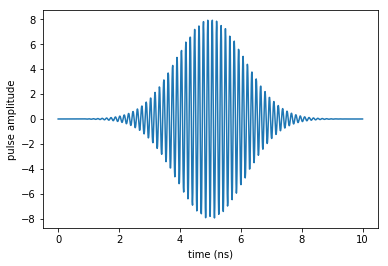

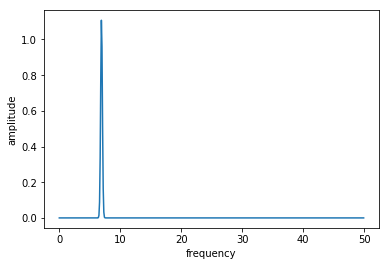

In [10]:
plot_pulse(H[1][1], tlist)
plot_spectrum(H[1][1], tlist)

For our guess pulse we have chosen to use an oscillating potential which is resonant with the energy gap between our states $\Delta E = E_1 - E_0 \approx 6.914$, shaped with a Gaussian function. The spectrum of the pulse shows this exact thing in the frequency decomposition. It is important to recall that this pulse is actually not referring to an electrical signal, but rather the electric potential that will be applied to the transmon circuit in which we are basing our system. 

We can also make sure that the oscillations are being computed with enough resolution: 

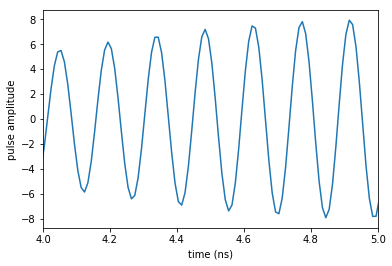

In [11]:
plot_pulse(H[1][1], tlist, xlimit=[4,5])

Once we are sure to have obtained the desired guess pulse, the dynamics for the initial guess can be found easily:

In [12]:
guess_dynamics = [objectives[x].mesolve(tlist, e_ops=[proj0, proj1]) for x in [0,1]]

In [13]:
def plot_population(result):
    '''Representation of the expected values for the initial states'''
    fig, ax = plt.subplots()
    ax.plot(result.times, result.expect[0], label='0')
    ax.plot(result.times, result.expect[1], label='1')
    ax.legend()
    ax.set_xlabel('time')
    ax.set_ylabel('population')
    
    plt.show(fig)

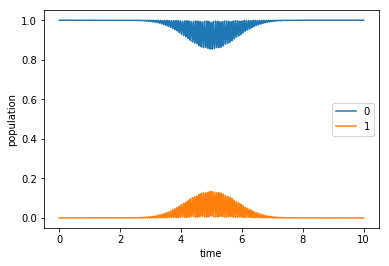

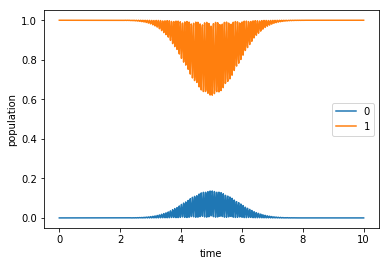

In [14]:
plot_population(guess_dynamics[0])
plot_population(guess_dynamics[1])

The initial guess can alter the population during the evolution of the system, but in the end it is not achieving the result that we are aiming for. Even though it is not an ideal pulse, we will try to optimize it. 

As a test, we can check whether our time step is sufficiently small by comparing the states that we are obtaining after the propagation with the ones that we would obtain with twice the amount of time steps. 

In [15]:
guess_states = [objectives[x].mesolve(tlist) for x in [0,1]]

In [16]:
tlist2 = np.linspace(0, tlist[-1], len(tlist)*2)
guess_states2 = [objectives[x].mesolve(tlist2) for x in [0,1]]

In [17]:
def state_overlap(result1, result2, index1, index2):
    
    print(abs(result1[0].states[index1].overlap(result2[0].states[index2])))
    print(abs(result1[1].states[index1].overlap(result2[1].states[index2])))
    

In [18]:
state_overlap(guess_states, guess_states2, -1, -1)

0.9999999999999853
0.9999999999971876


## Optimize

We now use all the information that we have gathered to initialize
the optimization routine. That is: 

* The `objectives`: creating an X-gate in the given basis. 

* The `pulse_options`: initial pulses and their shapes restrictions. 

* The `tlist`: time grid used for the propagation. 

* The `propagator`: propagation method that will be used.

* The `chi_constructor`: the optimization functional to use. 

* The `info_hook`: the subroutines to be called and data to be analized inbetween iterations.

* The `iter_stop`: the number of iterations to perform the optimization.

In [19]:
oct_result = krotov.optimize_pulses(
    objectives, pulse_options, tlist,
    propagator=krotov.propagators.expm,
    chi_constructor=krotov.functionals.chis_re,
    info_hook=print_fidelity, iter_stop=10)

Iteration 0: 	F = -0.000010
Iteration 1: 	F = 0.653868
Iteration 2: 	F = 0.749174
Iteration 3: 	F = 0.786936
Iteration 4: 	F = 0.803851
Iteration 5: 	F = 0.815087
Iteration 6: 	F = 0.823723
Iteration 7: 	F = 0.830559
Iteration 8: 	F = 0.836098
Iteration 9: 	F = 0.840722
Iteration 10: 	F = 0.844699


The fidelity in each step is then stored in the `info_vals` that are defined by the subroutines in `info_hook`:

In [20]:
def plot_convergence(result):
    fig, ax = plt.subplots()
    ax.semilogy(result.iters, 1-np.array(result.info_vals))
    ax.set_xlabel('OCT iteration')
    ax.set_ylabel('error')
    plt.show(fig)

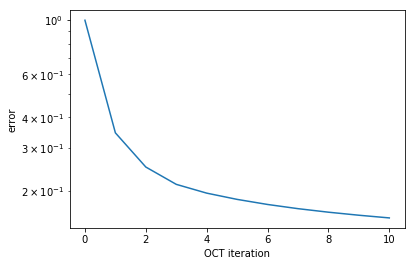

In [21]:
plot_convergence(oct_result)

## Simulate dynamics of the optimized pulse

We want to see how much the results have improved after the optimization. 

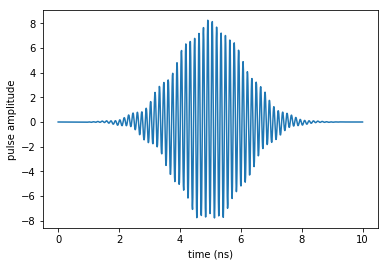

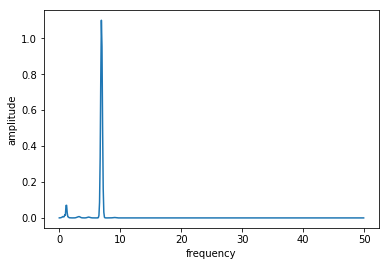

In [22]:
plot_pulse(oct_result.optimized_controls[0], tlist)
plot_spectrum(oct_result.optimized_controls[0], tlist)

In [23]:
opt_dynamics = [oct_result.optimized_objectives[x].mesolve(
    tlist, e_ops=[proj0, proj1]) for x in [0,1]]

/home/fernando/krotov/.venv/py36/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /home/fernando/krotov/docs/notebooks/rhs142620.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
/home/fernando/krotov/.venv/py36/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /home/fernando/krotov/docs/notebooks/rhs142621.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [24]:
opt_states = [oct_result.optimized_objectives[x].mesolve(tlist) for x in [0,1]]

/home/fernando/krotov/.venv/py36/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /home/fernando/krotov/docs/notebooks/rhs142622.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
/home/fernando/krotov/.venv/py36/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /home/fernando/krotov/docs/notebooks/rhs142623.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


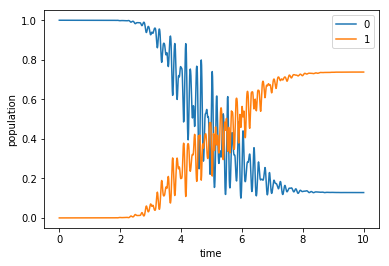

In [25]:
plot_population(opt_dynamics[0])

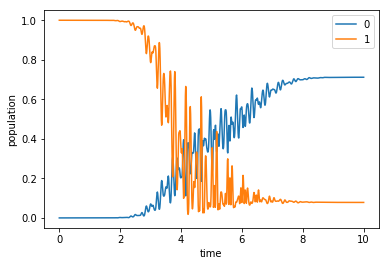

In [26]:
plot_population(opt_dynamics[1])

In this case we do not only care about the expected value for the states, but since we want to implement a gate it is necessary to check whether we are performing a coherent control. We are then interested in the phase difference that we obtain after propagating the states from the logic basis, which should be near to 0.  

In [27]:
def relative_phase(result):
    
    overlap_0 = np.angle(result[0].states[-1].overlap(psi1))
    overlap_1 = np.angle(result[1].states[-1].overlap(psi0))
    
    rel_phase = (overlap_0- overlap_1)%(2*np.pi)
    print('Final relative phase = '+str(rel_phase))

In [28]:
relative_phase(opt_states)

Final relative phase = 0.02701508754581751


We may also propagate the optimization result using the same propagator that was
used in the optimization (instead of `qutip.mesolve`). The main difference
between the two propagations is that `mesolve` assumes piecewise constant pulses
that switch between two points in `tlist`, whereas `propagate` assumes that
pulses are constant on the intervals of `tlist`, and thus switches *on* the
points in `tlist`.

In [29]:
opt_dynamics2 = [oct_result.optimized_objectives[x].propagate(
    tlist, e_ops=[proj0, proj1], propagator=krotov.propagators.expm) for x in [0,1]]

The difference between the two propagations gives an indication of the "time
discretization error". If this error were unacceptably large, we would need a
smaller time step.

In [30]:
"%.2e" % abs(opt_dynamics2[0].expect[1][-1] - opt_dynamics[0].expect[1][-1])

'2.81e-04'